In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import os

# **1. LOAD DATASET**

In [31]:
dataset = pd.read_csv("./dataset/combined_train_dataset.csv")
dataset = dataset[['X_LOC','Y_LOC','DEPT','NPHI','DTC','SP','RHOB','GR','CALI','Lithology_code']]
dataset.dropna(subset=['Lithology_code'])

,X_LOC,Y_LOC,DEPT,NPHI,DTC,SP,RHOB,GR,CALI,Lithology_code
7442,455221.34375,6533321.5,2645.580001,NaN,88.159820557,100.044289,NaN,73.558113,8.023255,65000.0
7443,455221.34375,6533321.5,2645.732002,NaN,88.72450256299999,100.293167,NaN,73.467598,8.024439,65000.0
7444,455221.34375,6533321.5,2645.884002,NaN,88.76322937,100.508331,NaN,72.116478,8.025548,65000.0
7445,455221.34375,6533321.5,2646.036002,NaN,val:88.972877502[UNIT],100.170883,NaN,69.835365,8.026745,65000.0
7446,455221.34375,6533321.5,2646.188002,NaN,val:89.675544739[UNIT],99.813011,NaN,67.834320,8.027942,65000.0
...,...,...,...,...,...,...,...,...,...,...
304276,483538.03125,6590314.0,1305.422000,NaN,NaN,138.276688,NaN,64.063187,12.278873,30000.0
304277,483538.03125,6590314.0,1305.574000,NaN,NaN,137.679504,NaN,63.323219,12.277086,30000.0
304278,483538.03125,6590314.0,1305.726000,NaN,NaN,137.264862,NaN,2901.263932,12.276823,30000.0
304279,483538.03125,6590314.0,1305.878000,NaN,NaN,137.055588,NaN,63.589741,12.277803,30000.0


In [35]:
dataset.shape

(304281, 11)

# **2. PREPROCESS DATASET**

## **2.1 CLEANING DTC AND CONVERT TO NUMBER**

In [32]:
# Fungsi untuk menghapus 'val:' dan '[UNIT]' serta konversi ke float
def clean_value(value):
    if isinstance(value, str):  # Pastikan nilai adalah string
        # Hapus 'val:' jika ada
        if 'val:' in value:
            value = value.replace('val:', '').strip()
        # Hapus '[UNIT]' jika ada
        if '[UNIT]' in value:
            value = value.replace('[UNIT]', '').strip()
        # Coba konversi ke float
        try:
            return float(value)
        except ValueError:
            return value  # Kembalikan asli jika gagal konversi
    # Jika bukan string (misalnya sudah float), kembalikan apa adanya
    try:
        return float(value)
    except (ValueError, TypeError):
        return value  # Kembalikan asli jika gagal konversi

# Terapkan fungsi ke kolom DTC
dataset['DTC'] = dataset['DTC'].apply(clean_value)

## **2.2 FILL NAN LOCATION FEATURE WITH ZERO**

In [33]:
dataset['X_LOC'].fillna(0,inplace=True)
dataset['Y_LOC'].fillna(0,inplace=True)

## **2.3 CREATE CLUSTER FEATURE BY (X_LOC AND DEPT)**

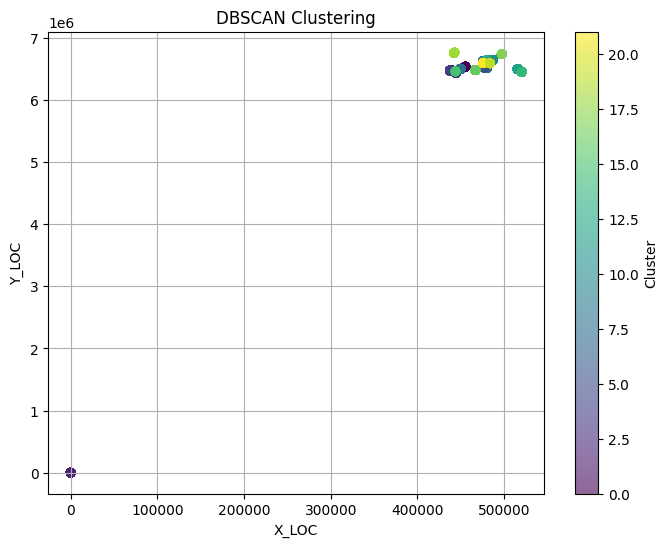

In [34]:
# Get indices of non-null X_LOC and Y_LOC values
valid_indices = dataset[['X_LOC', 'Y_LOC']].dropna().index

# Get X array for clustering
X = dataset.loc[valid_indices, ['X_LOC', 'Y_LOC']].astype(int).values

# Gunakan eps berdasarkan k-dist plot
dbscan = DBSCAN(eps=1, min_samples=5)
clusters = dbscan.fit_predict(X)

# Tambahkan hasil klaster ke dataset
dataset.loc[valid_indices, 'Cluster_DBSCAN'] = clusters

# Plot hasil clustering
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.6)
plt.xlabel('X_LOC')
plt.ylabel('Y_LOC')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

## **2.4 SPLIT DATASET BY CLUSTER**

In [36]:
clusters = dataset['Cluster_DBSCAN'].dropna().unique()  # Ambil semua cluster unik

# Buat dictionary untuk menyimpan DataFrame tiap cluster
cluster_dfs = {}

for cluster in clusters:
    cluster_dfs[cluster] = dataset[dataset['Cluster_DBSCAN'] == cluster].copy()

In [37]:
# Buat folder utama untuk menyimpan dataset per cluster
output_folder = 'dataset_cluster'
os.makedirs(output_folder, exist_ok=True)

# Iterasi setiap cluster dan simpan sebagai file CSV
for cluster, df in cluster_dfs.items():
    # Tentukan nama file dengan format "(nama_cluster)_dataset.csv"
    filename = f"{cluster}_dataset.csv"
    filepath = os.path.join(output_folder, filename)

    # Simpan DataFrame ke CSV
    df.to_csv(filepath, index=False)

## **2.5 FILL NAN BY ORDERING DEPT**

In [38]:
for cluster, df in cluster_dfs.items():
    # Urutkan data berdasarkan DEPT
    df = df.sort_values(by='DEPT')
    
    # Reset index untuk memudahkan akses
    df = df.reset_index(drop=True)
    
    # Ambil kolom numerik (kecuali Lithology_code)
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # Buat mask untuk melacak NaN awal
    nan_mask = df[numeric_cols].isna()
    
    # Forward Fill (ffill) dengan batasan jarak dan Lithology_code
    for col in numeric_cols:
        # Kondisi: Lithology_code sama dan selisih DEPT < threshold
        condition_ffill = (df['Lithology_code'].shift(-1) == df['Lithology_code'])
        df[col] = df[col].where(~nan_mask[col] | ~condition_ffill, df[col].shift(-1))
    
    # Backward Fill (bfill) dengan batasan jarak dan Lithology_code
    for col in numeric_cols:
        # Kondisi: Lithology_code sama dan selisih DEPT < threshold
        condition_bfill = (df['Lithology_code'].shift(1) == df['Lithology_code'])
        df[col] = df[col].where(~nan_mask[col] | ~condition_bfill, df[col].shift(1))
    
    # Logging: Hitung jumlah NaN yang diisi dengan setiap metode
    ffill_count = nan_mask.sum() - df[numeric_cols].isna().sum()
    bfill_count = nan_mask.sum() - df[numeric_cols].isna().sum() - ffill_count
    
    # Simpan kembali ke cluster_dfs
    cluster_dfs[cluster] = df

## **2.6 LABELLING OUTLIER**

In [39]:
# 1. Pilih fitur untuk analisis (exclude specified columns)
exclude_cols = ['Lithology_code', 'X_LOC', 'Y_LOC', 'DEPT','Cluster_DBSCAN']
numeric_cols = [col for col in dataset.select_dtypes('number').columns if col not in exclude_cols]

# 2. Definisikan fungsi untuk mendeteksi outlier
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    is_outlier = (df[column] < lower_bound) | (df[column] > upper_bound)
    return is_outlier, lower_bound, upper_bound

# 3. Labeling outlier untuk setiap cluster
for cluster, df_cluster in cluster_dfs.items():
    # Buat DataFrame untuk menyimpan status outlier
    outlier_mask = pd.DataFrame(index=df_cluster.index)
    
    # Deteksi outlier untuk setiap kolom numerik
    for col in numeric_cols:
        if df_cluster[col].notna().any():  # Only process columns with non-null values
            is_outlier, lower_bound, upper_bound = detect_outliers(df_cluster, col)
            outlier_mask[f'{col}_is_outlier'] = is_outlier
         
    # Tambahkan status outlier ke DataFrame cluster
    cluster_dfs[cluster] = df_cluster.join(outlier_mask)

## **2.7 SPLIT BY CLASS ON EACH CLUSTER**

In [40]:
# Dictionary bertingkat untuk menyimpan data berdasarkan cluster dan lithology
cluster_lithology_dfs = {}

for cluster in cluster_dfs.keys():
    # Split lagi berdasarkan Lithology_code
    lithology_codes = cluster_dfs[cluster]['Lithology_code'].dropna().unique()
    
    # Dictionary dalam dictionary untuk Lithology_code per cluster
    cluster_lithology_dfs[cluster] = {}

    for litho in lithology_codes:
        cluster_lithology_dfs[cluster][litho] = cluster_dfs[cluster][cluster_dfs[cluster]['Lithology_code'] == litho].copy()

In [41]:
# Folder utama untuk menyimpan dataset per cluster dan lithology
main_folder = 'dataset_cluster_class'
os.makedirs(main_folder, exist_ok=True)

# Iterasi setiap cluster dan lithology
for cluster, lithology_dict in cluster_lithology_dfs.items():
    # Buat subfolder untuk cluster (misalnya "1", "2", dst.)
    cluster_folder = os.path.join(main_folder, str(cluster))
    os.makedirs(cluster_folder, exist_ok=True)
    
    for lithology_code, df in lithology_dict.items():
        # Tentukan nama file sesuai lithology_code
        filename = f"{lithology_code}.csv"
        filepath = os.path.join(cluster_folder, filename)

        # Simpan DataFrame ke CSV
        df.to_csv(filepath, index=False)

## **2.8 INTERPOLATE OUTLIER**

In [45]:
# Folder utama tempat dataset tersimpan
main_folder = 'dataset_cluster_class'

# Iterasi setiap subfolder (cluster)
for cluster_folder in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_folder)

    # Periksa apakah path adalah folder
    if os.path.isdir(cluster_path):
        # print(f"Opening folder: {cluster_folder}")

        # Iterasi setiap file dalam folder cluster
        for filename in os.listdir(cluster_path):
            file_path = os.path.join(cluster_path, filename)

            # Periksa apakah file adalah CSV
            if filename.endswith('.csv'):
                # print(f"Reading file: {filename}")

                # Buka file CSV sebagai DataFrame
                df = pd.read_csv(file_path)
                
                # Get list of outlier columns
                outlier_cols = [col for col in df.columns if "outlier" in col]
                
                if outlier_cols:  # If there are outlier columns
                    # Get corresponding feature columns (remove '_is_outlier' suffix)
                    feature_cols = [col.replace('_is_outlier', '') for col in outlier_cols]
                    
                    for feature, outlier_col in zip(feature_cols, outlier_cols):
                        if outlier_col in df.columns:
                            # Simpan mask NaN asli sebelum mengganti outlier dengan NaN
                            mask_nan_original = df[feature].isna()

                            # Mask untuk outlier
                            mask_outliers = df[outlier_col] == True  

                            # Ganti hanya outlier dengan NaN
                            df.loc[mask_outliers, feature] = None  

                            # Lakukan interpolasi
                            df[feature] = df[feature].interpolate(method='linear')

                            # Kembalikan NaN asli ke posisi semula
                            df.loc[mask_nan_original, feature] = None  
                    
                    # Save the updated DataFrame
                    df.to_csv(file_path, index=False)

# **3. FILL NAN VALUE**

## **3.1 FILL NAN VALUE WITH KNN IN EACH CLASS IN EACH CLUSTER** 

| **Data** | **Predictors** |
|----------|--------------|
| NPHI     | RHOB, DTC, DEPT |
| DTC      | RHOB, NPHI, DEPT |
| SP       | GR, DEPT |
| RHOB     | NPHI, DTC, DEPT |
| GR       | DEPT, SP |
| CALI     | DEPT |

In [47]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Definisi hubungan fitur untuk imputasi
imputation_dict = {
    'NPHI': ['RHOB', 'DTC', 'DEPT'],
    'DTC': ['RHOB', 'NPHI', 'DEPT'],
    'SP': ['GR', 'DEPT'],
    'RHOB': ['NPHI', 'DTC', 'DEPT'],
    'GR': ['DEPT', 'SP'],
    'CALI': ['DEPT']
}

def impute_feature(df, target_feature, predictor_features):
    # Periksa apakah kolom target 100% NaN
    if df[target_feature].isna().sum() == len(df):
        print(f"Skipping {target_feature}: 100% NaN.")
        return df  # Kembalikan DataFrame tanpa perubahan
    
    # Periksa apakah semua kolom prediktor 100% NaN
    valid_predictors = [col for col in predictor_features if df[col].isna().sum() < len(df)]
    
    if len(valid_predictors) == 0:
        print(f"Skipping {target_feature}: All predictor columns are 100% NaN.")
        return df  # Kembalikan DataFrame tanpa perubahan

    # Cek apakah ada NaN yang perlu diimputasi di target
    if df[target_feature].isna().sum() > 0:
        print(f"Imputing {target_feature} using {valid_predictors}...")

        # Ambil subset data dengan fitur prediktor valid dan target
        imputation_data = df[valid_predictors + [target_feature]].copy()

        # Standarisasi data
        scaler = StandardScaler()
        imputation_data_scaled = scaler.fit_transform(imputation_data)

        # Terapkan KNN Imputer
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        imputed_data_scaled = imputer.fit_transform(imputation_data_scaled)

        # Kembalikan ke skala asli
        imputed_data = scaler.inverse_transform(imputed_data_scaled)
        imputed_df = pd.DataFrame(imputed_data, columns=valid_predictors + [target_feature], index=df.index)

        # Update DataFrame asli
        df[target_feature] = imputed_df[target_feature]
    else:
        print(f"No NaN values in {target_feature}. Skipping imputation.")
    
    return df

In [48]:
# Path ke folder utama yang berisi subfolder cluster
main_folder = 'dataset_cluster_class'  # Ganti dengan path folder utama Anda

# Iterasi setiap subfolder (cluster)
for cluster_folder in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_folder)

    # Periksa apakah path adalah folder
    if os.path.isdir(cluster_path):
        print(f"Processing folder: {cluster_folder}")

        # Iterasi setiap file dalam folder cluster
        for filename in os.listdir(cluster_path):
            file_path = os.path.join(cluster_path, filename)

            # Periksa apakah file adalah CSV
            if filename.endswith('.csv'):
                print(f"Reading file: {filename}")

                # Buka file CSV sebagai DataFrame
                df = pd.read_csv(file_path)

                # Lakukan imputasi untuk setiap fitur target
                for target_feature, predictor_features in imputation_dict.items():
                    # Pastikan semua fitur prediktor ada di DataFrame
                    if all(feature in df.columns for feature in predictor_features):
                        df = impute_feature(df, target_feature, predictor_features)
                    else:
                        print(f"Skipping imputation for {target_feature}: missing predictors in {filename}")

                # Simpan kembali file CSV yang telah diimputasi
                df.to_csv(file_path, index=False)
                print(f"Saved imputed file: {filename}")

Processing folder: 0.0
Reading file: 30000.0.csv
No NaN values in NPHI. Skipping imputation.
No NaN values in DTC. Skipping imputation.
No NaN values in SP. Skipping imputation.
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skipping imputation.
No NaN values in CALI. Skipping imputation.
Saved imputed file: 30000.0.csv
Reading file: 65000.0.csv
Imputing NPHI using ['RHOB', 'DTC', 'DEPT']...
No NaN values in DTC. Skipping imputation.
No NaN values in SP. Skipping imputation.
Imputing RHOB using ['NPHI', 'DTC', 'DEPT']...
No NaN values in GR. Skipping imputation.
No NaN values in CALI. Skipping imputation.
Saved imputed file: 65000.0.csv
Reading file: 70000.0.csv
No NaN values in NPHI. Skipping imputation.
No NaN values in DTC. Skipping imputation.
No NaN values in SP. Skipping imputation.
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skipping imputation.
No NaN values in CALI. Skipping imputation.
Saved imputed file: 70000.0.csv
Reading file: 74000.

## **3.2 JOIN EACH CLUSTER DATASET TO EACH CLASS DATASET** 

In [49]:
main_folder = "dataset_cluster_class"  # Ganti dengan nama folder utama jika berbeda
merged_df_list = []  # List untuk menyimpan DataFrame sebelum digabung

# Iterasi setiap subfolder (cluster)
for cluster_folder in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_folder)

    # Periksa apakah path adalah folder
    if os.path.isdir(cluster_path):
        # print(f"Processing folder: {cluster_folder}")

        # Iterasi setiap file dalam folder cluster
        for filename in os.listdir(cluster_path):
            file_path = os.path.join(cluster_path, filename)

            # Periksa apakah file adalah CSV
            if filename.endswith('.csv'):
                # print(f"Reading file: {filename}")

                # Buka file CSV sebagai DataFrame
                df = pd.read_csv(file_path)

                # Tambahkan ke daftar DataFrame
                merged_df_list.append(df)

# Gabungkan semua DataFrame dalam daftar
if merged_df_list:
    merged_df = pd.concat(merged_df_list, ignore_index=True)

    # Simpan sebagai satu file CSV gabungan
    merged_csv_path = os.path.join(main_folder, "merged_dataset.csv")
    merged_df.to_csv(merged_csv_path, index=False)
    print(f"Saved merged dataset: {merged_csv_path}")
else:
    print("No CSV files found to merge.")

merged_df = merged_df[[i for i in merged_df.columns if "outlier" not in i]]

lithology_code = merged_df['Lithology_code'].dropna().unique()  # Ambil semua cluster unik

# Buat dictionary untuk menyimpan DataFrame tiap cluster
lithology_df = {}

for code in lithology_code:
    lithology_df[code] = merged_df[merged_df['Lithology_code'] == code].copy()
    
# Buat folder utama untuk menyimpan dataset per cluster
output_folder = 'dataset_lithology'
os.makedirs(output_folder, exist_ok=True)

# Iterasi setiap cluster dan simpan sebagai file CSV
for code, df in lithology_df.items():
    # Tentukan nama file dengan format "(nama_code)_dataset.csv"
    filename = f"{code}_dataset.csv"
    filepath = os.path.join(output_folder, filename)

    # Simpan DataFrame ke CSV
    df.to_csv(filepath, index=False)

Saved merged dataset: dataset_cluster_class\merged_dataset.csv


In [50]:
merged_df

,X_LOC,Y_LOC,DEPT,NPHI,DTC,SP,RHOB,GR,CALI,Lithology_code,Cluster_DBSCAN
0,455221.34375,6533321.5,2712.460002,0.218318,71.954613,115.249199,2.257217,58.311520,14.666450,30000.0,0.0
1,455221.34375,6533321.5,2726.596002,0.085455,59.167652,107.675835,2.548615,88.030212,12.509160,30000.0,0.0
2,455221.34375,6533321.5,2726.748002,0.114017,60.975471,106.604393,2.518298,86.302811,12.547709,30000.0,0.0
3,455221.34375,6533321.5,2726.900002,0.147875,62.972198,105.224342,2.492360,79.648369,12.620093,30000.0,0.0
4,455221.34375,6533321.5,2727.052002,0.180865,64.157539,103.775002,2.470284,67.485962,12.537360,30000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
250395,475882.21875,6621553.0,2238.192000,NaN,112.132500,85.751999,2.327521,44.279440,13.171748,99000.0,9.0
250396,475882.21875,6621553.0,2238.344000,NaN,111.552429,86.463982,2.340207,46.894100,13.179663,99000.0,9.0
250397,475882.21875,6621553.0,2238.496000,NaN,110.810074,88.444344,2.352964,45.771843,13.399187,99000.0,9.0
250398,475882.21875,6621553.0,2238.648000,NaN,109.873856,90.435295,2.382930,42.283649,13.746966,99000.0,9.0


## **3.3 FILL NAN VALUE WITH KNN IN EACH CLASS** 

| **Data** | **Predictors** |
|----------|--------------|
| NPHI     | RHOB, DTC, DEPT |
| DTC      | RHOB, NPHI, DEPT |
| SP       | GR, DEPT |
| RHOB     | NPHI, DTC, DEPT |
| GR       | DEPT, SP |
| CALI     | DEPT |

In [ ]:
main_folder = 'dataset_lithology'

# Iterate through files in the main folder
for filename in os.listdir(main_folder):
    file_path = os.path.join(main_folder, filename)
    
    # Check if file is CSV
    if filename.endswith('.csv'):
        print(f"Reading file: {filename}")

        # Read CSV as DataFrame
        df = pd.read_csv(file_path)

        # Perform imputation for each target feature
        for target_feature, predictor_features in imputation_dict.items():
            # Make sure all predictor features exist in DataFrame
            if all(feature in df.columns for feature in predictor_features):
                df = impute_feature(df, target_feature, predictor_features)
            else:
                print(f"Skipping imputation for {target_feature}: missing predictors in {filename}")

        # Save back the imputed CSV file
        df.to_csv(file_path, index=False)
        print(f"Saved imputed file: {filename}")

Reading file: 30000.0_dataset.csv
Imputing NPHI using ['RHOB', 'DTC', 'DEPT']...
Imputing DTC using ['RHOB', 'NPHI', 'DEPT']...
Imputing SP using ['GR', 'DEPT']...
Imputing RHOB using ['NPHI', 'DTC', 'DEPT']...
Imputing GR using ['DEPT', 'SP']...
Imputing CALI using ['DEPT']...
Saved imputed file: 30000.0_dataset.csv
Reading file: 65000.0_dataset.csv
Imputing NPHI using ['RHOB', 'DTC', 'DEPT']...


In [17]:
main_folder = "dataset_lithology"  # Main folder containing lithology CSV files
merged_df_list = []  # List to store DataFrames before merging

# Iterate through files in the main folder
for filename in os.listdir(main_folder):
    file_path = os.path.join(main_folder, filename)

    # Check if file is CSV
    if filename.endswith('.csv'):
        # Read CSV as DataFrame
        df = pd.read_csv(file_path)
        merged_df_list.append(df)

# Merge all DataFrames in the list
if merged_df_list:
    merged_df = pd.concat(merged_df_list, ignore_index=True)

    # Save as one merged CSV file
    merged_csv_path = os.path.join(main_folder, "merged_dataset.csv")
    merged_df.to_csv(merged_csv_path, index=False)
    merged_df.to_csv("./dataset/cleaned_dataset.csv", index=False)
    print(f"Saved merged dataset: {merged_csv_path}")
else:
    print("No CSV files found to merge.")
    
merged_df.drop(columns=['Cluster_DBSCAN'],inplace=True)

Saved merged dataset: dataset_lithology\merged_dataset.csv


In [27]:
merged_df

,X_LOC,Y_LOC,DEPT,NPHI,DTC,SP,RHOB,GR,CALI,Lithology_code
0,455221.34375,6533321.5,2712.460002,0.218318,71.954613,115.249199,2.257217,58.311520,14.666450,30000.0
1,455221.34375,6533321.5,2726.596002,0.085455,59.167652,107.675835,2.548615,88.030212,12.509160,30000.0
2,455221.34375,6533321.5,2726.748002,0.114017,60.975471,106.604393,2.518298,86.302811,12.547709,30000.0
3,455221.34375,6533321.5,2726.900002,0.147875,62.972198,105.224342,2.492360,79.648369,12.620093,30000.0
4,455221.34375,6533321.5,2727.052002,0.180865,64.157539,103.775002,2.470284,67.485962,12.537360,30000.0
...,...,...,...,...,...,...,...,...,...,...
500795,475879.87500,6621553.5,NaN,0.552879,127.038727,85.580566,1.859015,45.243328,14.394629,99000.0
500796,475879.84375,6621553.5,NaN,0.551750,129.599304,85.835159,1.869647,49.286884,14.290564,99000.0
500797,475879.84375,6621553.5,NaN,0.522555,132.207581,85.997223,1.938496,52.509357,13.582817,99000.0
500798,475879.84375,6621553.5,NaN,0.455286,132.276276,86.289757,2.045645,54.329918,13.063447,99000.0
